# Land Use and Land Cover Classification using Pytorch

In this two-part tutorial, you will learn how to:
- train a deep learning model for image classification using Pytorch
- generate land use and land cover maps using Python GIS

# Overview

This notebook covers an an introduction to image classification using Pytorch for land use and land cover (LULC) mapping. 
We will be able to: 
- classify satellite images into 10 LULC categories using the EuroSAT dataset
- Fine-turn a ResNet-50 CNN model for image classification
- Save and Load trained models in Pytorch

<a name="climate-impact"></a>
# Climate Impact
A [report](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) by the World Resources Institute (WRI) states that about 23% of global human-caused GHG emissions come from land uses such as agriculture, forestry, and urban expansion. Land use change such as deforestation and land degradation are among the primary drivers of these emissions. Rapid urbanization leading to an increase in built-up areas as well as a massive loss of terrestrial carbon storage can also result in large carbon emissions.

Mapping the extent of land use and land cover categories over time is essential for better environmental monitoring, urban planning and nature protection. For example, monitoring changes in forest cover and identifying drivers of forest loss can be useful for forest conservation and restoration efforts. Assessing the vulnerability of certain land cover types, such as settlements and agricultural land, to certain risks can also be useful for for disaster risk reduction planning as well as long-term climate adaptation efforts.

With the increasing availability of earth observation data coupled with recent advanced in computer vision, AI & EO has paved the way for the potential to map land use and land cover at an unprecedented scale. In this tutorial, we will explore the use of Sentinel-2 satellite images and deep learning models in Pytorch to automate LULC mapping.
<br>
<center><p><p> <img src="https://ptes.org/wp-content/uploads/2018/04/iStock-664630460-e1524839082464.jpg" alt="alt" width="50%"/>

# Importing Required Libraries

In [45]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Check that the GPU is enabled. 

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


# Data Description
- Download the EuroSAT dataset 
- Generate the train and test sets 
- Visualize a sample of images 

## EuroSAT dataset
The EuroSAT dataset contains 27,000 labelled 64x64 pixel Sentiel-2 satellite image patches with 10 different LULC categories. 

In [44]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-08-09 08:39:19--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  6.94MB/s    in 15s     

2024-08-09 08:39:34 (5.99 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

replace EuroSAT/2750/River/River_479.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Generate Train and Test Sets
We wiill create custom Pytorch Dataset to help us in loading the data we want from the source folder

In [47]:
class EuroSAT(data.Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform
    def __getitem__(self,index):
        #Apply image transformation if transform is set to true
        if self.transform: 
            x = self.transform(dataset[index],[0])
        else: 
            x = dataset[index][0]
        # get the corresponding label 
        y = dataset[index][1]
        return x,y

    def __len__(self):
        return len(dataset)

## Image Transformations
- In this section, we will define transformations that we want to apply to our images. We will apply data augumentation to our training set and also normalize our images to the normals of the large imagenet dataset.
- Note: While the augumentation will be done on the training set, we will not do augumentation to the validation and test sets. The only reason we wan to do augumentation to the training set is to train the model to be able to identify objects in different orientations. There is no point of doing data augumentation to the validation and the test sets.

In [48]:
input_size = 224
imagenet_mean , imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(imagenet_mean,imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size), 
    transforms.CenterCrop(input_size), 
    transforms.ToTensor(), 
    transforms.Normalize(imagenet_mean,imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size), 
    transforms.CenterCrop(input_size), 
    transforms.ToTensor(), 
    transforms.Normalize(imagenet_mean,imagenet_std)
    
])

## Load EuroSAT DataSet
- Now we have define all the transformations, we are ready to load the EuroSAT dataset. We will use the torch's ImageFolder class to parse the source folder of our images.

  `ImageFolder` is a generic data loader where the images are arranged in this way:

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```

In [49]:
# load the dataset 
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)
dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ./EuroSAT/2750/

In [50]:
# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


## Split into Train, Validation and Test Sets
- Here, we split the dataset into a train set and test set. Training set will be 70% of the EuroSAT dataset, randomly selected.
- We set aside 15% of the dataset as our validation set and the remaining 15% as our test set.

In [51]:
# Apply different transformations to the training and test set.
train_data = EuroSAT(dataset,train_transform)
val_data = EuroSAT(dataset,val_transform)
test_data = EuroSAT(dataset,test_transform)

# Randomly split the dataset into 70% train, 15% val and 15% test 

train_size = 0.7
val_size = 0.15 
indices = list(range(int(len(dataset))))
train_split = int(train_size*len(dataset))
val_split = int(val_size*len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data,indices=indices[:train_split])
val_data = data.Subset(val_data,indices=indices[train_split:train_split+val_split])
test_data = data.Subset(test_data,indices=indices[train_split+val_split:])

print("Train/val/test sizes: {}/{}/{}".format(len(train_data),len(val_data),len(test_data)))
      

Train/val/test sizes: 18900/4050/4050


Finally, we use torch's DataLoader class to create a dataloader. The dataloader managers fetching samples from the datasets (it can even
fetch them in parallel using num_workers) and assembles batches of datasets.

In [52]:
num_workers = 2 
batch_size = 16 

train_loader = data.DataLoader(
    train_data,batch_size=batch_size,num_workers=num_workers,shuffle=True
)
val_loader = data.DataLoader(
    val_data,batch_size=batch_size,num_workers=num_workers,shuffle=False
)
test_loader = data.DataLoader(
    test_data,batch_size=batch_size,num_workers=num_workers,shuffle=False
)

## Visualize Data

In the cell below, we will visualize a batch of the dataset.

In [ ]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

## Exploratory Data Analysis
Next, lets explore our dataset a little bit more. In particular, how many images of each class are included?

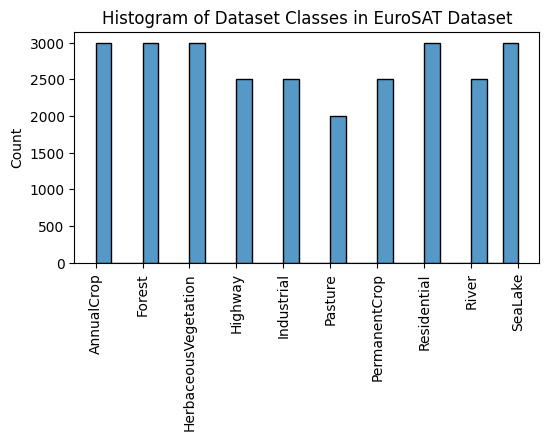

In [55]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

## Model Development

## Instantiate Model
First, lets instantiate the model. We will use a standard neural network architecture, ResNet50. 

In [58]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features,len(dataset.classes))
model = model.to(device)
torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation 
During model training and evaluation, we are interested in 3 main things.
- Specify the criterion, optimizer and hyperparameters (e.g n_epochs, learning rate etc)
- Train the model on the training set by updating its weights to minimize the loss function.
- Evaluate the model on the test set to observe performance on new, unseen data.
- Repeat steps 2 and 3 n_epochs times. 

In [60]:
# specify the number of epochs and the learning rate: 
n_epochs = 10 
lr = 1e-3

#specify criterion and the optimizer 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


Next, lets create our training function

In [62]:
def train(model,dataloader,criterion,optimizer): 
    model.train()

    running_loss = 0.0 
    running_total_correct = 0.0 

    for i, (inputs,labels) in enumerate((tqdmdataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients 
        # clear off previous weights in order to obtain updated weights

        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs)

        # compute the loss
        loss = criterion(outputs,labels)

        # compute the gradients wrt to the loss
        loss.backward()

        # update the weights based on the internally stored gradients 
        optimizer.step()

        # calculate statistics: 
        _, preds = torch.max(outputs,1)

        # calculate running loss and accuracy 
        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = (running_total_correct / len(dataloader.dataset))*100
        print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

        return epoch_loss,epoch_accuracy
        
        
        